## Project - Hospitality App New User Bookings

### Objective

1. You need to do basic feature engineering, data preprocessing, modelling and model tuning work in this homework.

2. Please **focus more on feature extractions**. In this project, there are a lot of interesting features, how to fully utilize them is the key to get a good model.


### Hints
1. Data Exploration
2. Data Processing
3. Feature Engineering
4. Model Building

In [1]:
## import necessary packages
import numpy as np
import pandas as pd
import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
user_booking = pd.read_csv('dataset/user_bookings.csv')

In [3]:
print(user_booking.shape)
print(user_booking.columns)

(213451, 16)
Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')


dataset

o	id: user id <br /> 
o	date_account_created: the date of account creation <br /> 
o	timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up <br /> 
o	date_first_booking: date of first booking <br /> 
o	gender <br /> 
o	age <br /> 
o	signup_method <br /> 
o	signup_flow: the page a user came to signup up from <br /> 
o	language: international language preference <br /> 
o	affiliate_channel: what kind of paid marketing <br /> 
o	affiliate_provider: where the marketing is e.g. google, craigslist, other <br /> 
o	first_affiliate_tracked: whats the first marketing the user interacted with before the signing up <br /> 
o	signup_app <br /> 
o	first_device_type <br /> 
o	first_browser <br /> 
o	country_destination: this is the target variable you are to predict <br /> 

## 1. Data Exploration

In [4]:
user_booking.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
user_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


## 2. EDA

#### Uni-variate analysis

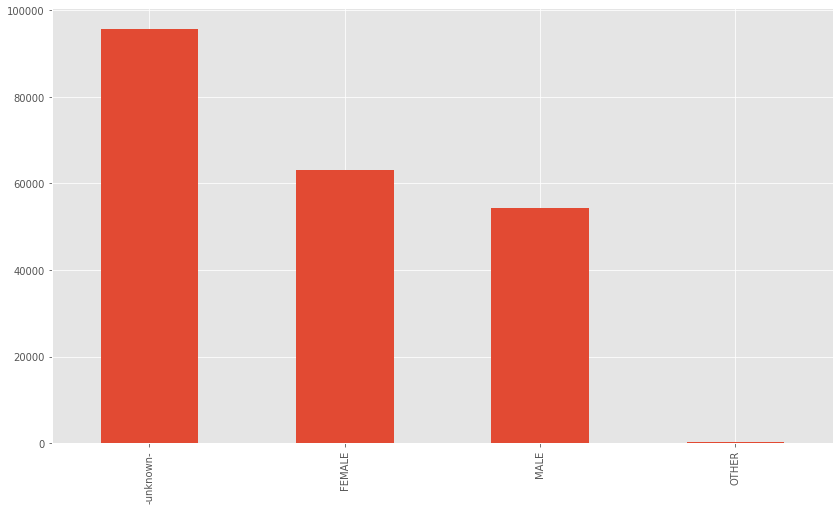

In [6]:
# explore the gender
plt.figure(figsize=[14,8])
user_booking.gender.value_counts().plot.bar()

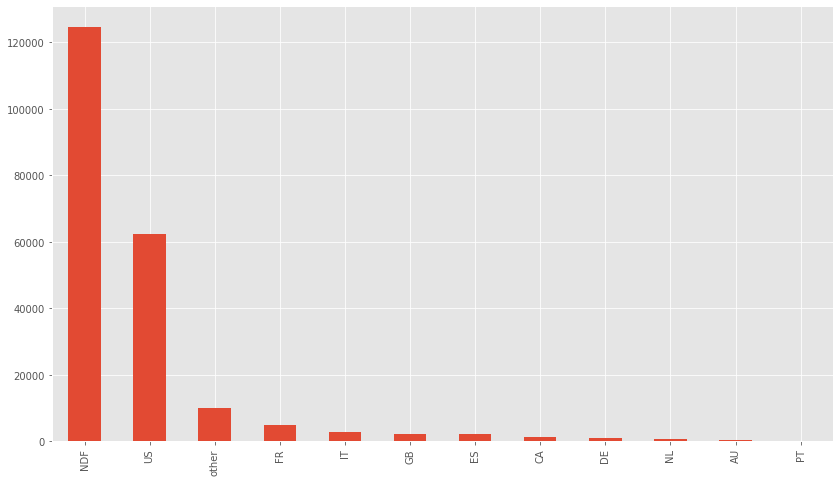

In [7]:
# see the distribution of destination
plt.figure(figsize=[14,8])
user_booking.country_destination.value_counts().plot.bar()

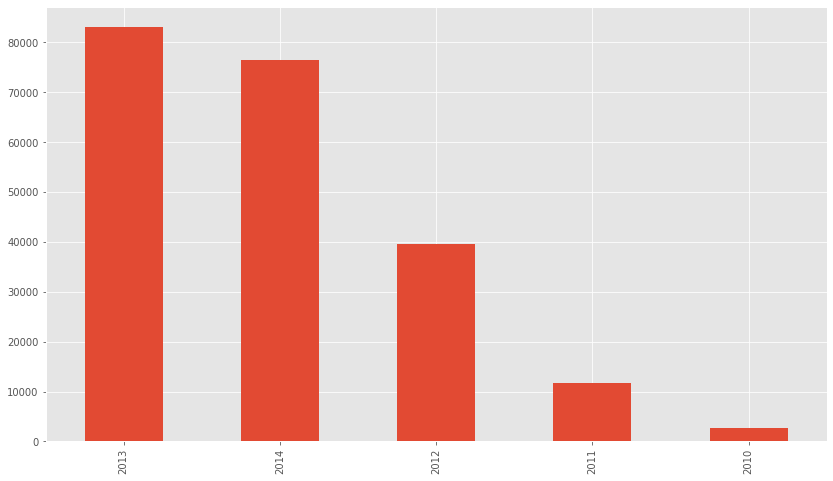

In [8]:
# explore date account created
plt.figure(figsize=[14,8])
pd.to_datetime(user_booking.date_account_created).dt.year.value_counts().plot.bar()

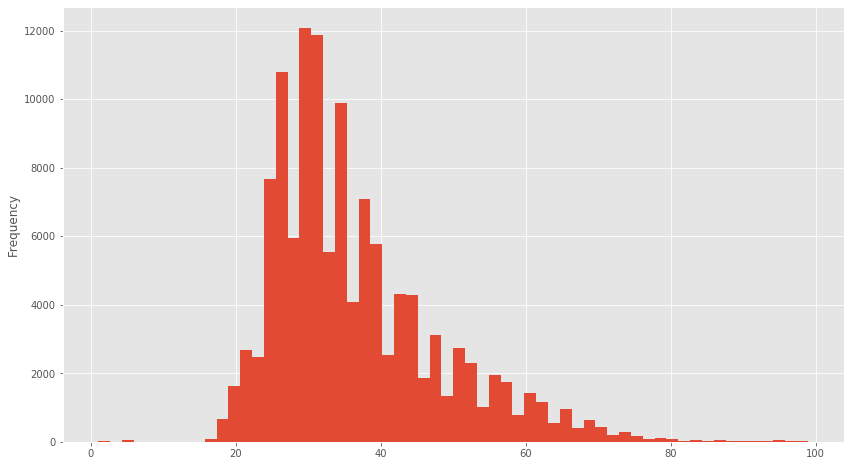

In [9]:
# see the age distribution
plt.figure(figsize=[14,8])
user_booking.loc[user_booking.age < 100].age.plot.hist(bins=60)

### Bi-variate analysis

Text(0.5, 1.0, 'Gender-Age Distribution')

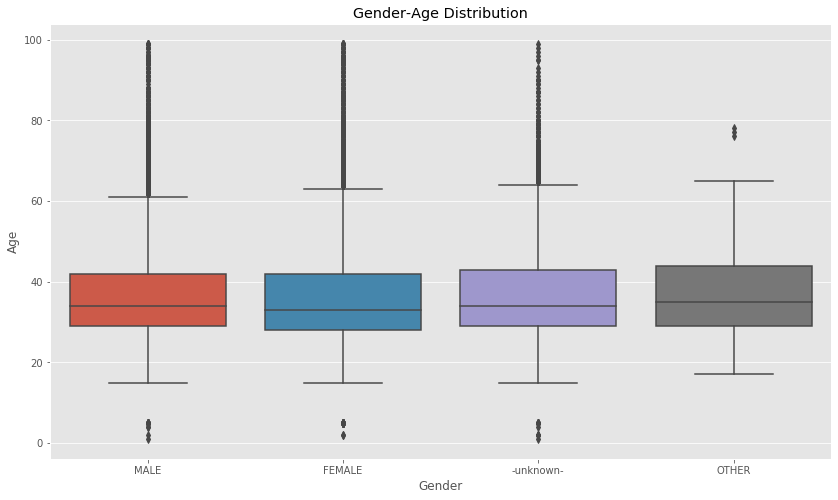

In [10]:
#Gender-Age Distribution plot

plt.figure(figsize=[14,8])
sns.boxplot(data=user_booking[user_booking.age < 100],y='age',x='gender')
# plt.ylim(18,100)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Gender-Age Distribution')

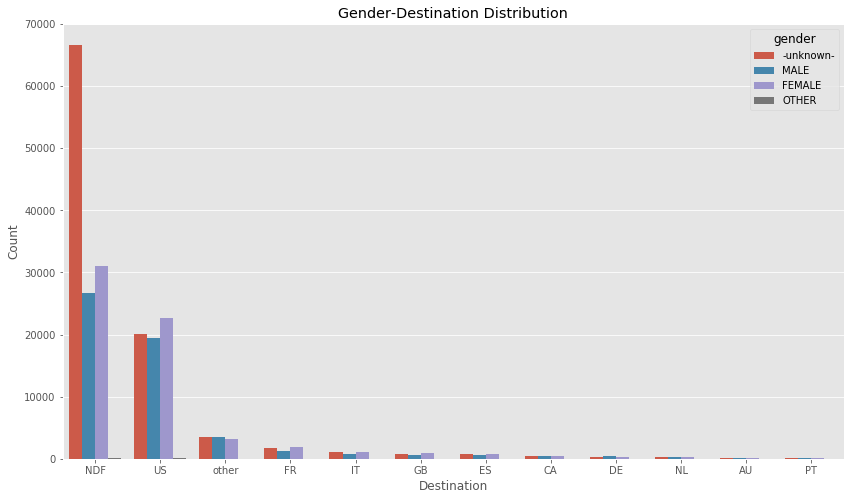

In [11]:
#Gender-Destination Distribution Plot

plt.figure(figsize=(14,8))
order1 = user_booking['country_destination'].value_counts().index
sns.countplot(data = user_booking, x = 'country_destination', order = order1,hue='gender')
plt.xlabel('Destination')
plt.ylabel('Count')
plt.title('Gender-Destination Distribution')
order2 = user_booking['country_destination'].value_counts()

## 3. Feature Engineering

In [12]:
# The label we need to predict
labels = user_booking['country_destination'].values

# drop the id column
# drop the date_first_booking because when we predict for new user, they don't have booking info
# drop the label in training set
user_booking.drop(['id', 'country_destination', 'date_first_booking'], axis = 1, inplace = True)

#### date_account_created （dac）

In [13]:
# create year, month, day feature for dac
dac = pd.to_datetime(user_booking.date_account_created)
user_booking['dac_year'] = np.array([x.year for x in dac])
user_booking['dac_month'] = np.array([x.month for x in dac])
user_booking['dac_day'] = np.array([x.day for x in dac])

In [14]:
# create features of weekday for dac, showing Monday to Sunday
user_booking['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(user_booking.dac_wd, prefix = 'dac_wd')
user_booking = pd.concat((user_booking, df_dac_wd), axis = 1)
user_booking.drop(['dac_wd'], axis = 1, inplace = True)

In [15]:
def get_season(dt):
    dt = dt.date()
    # dt must be a datetime type
    if dt.month in [3,4,5]:
        return 'Spring'    
    elif dt.month in [6,7,8]:
        return 'Summer'    
    elif dt.month in [9,10,11]:
        return 'Fall'   
    else:
        return 'Winter' 

In [16]:
# create season features from dac
user_booking['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(user_booking.dac_season, prefix = 'dac_season')
user_booking = pd.concat((user_booking, df_dac_season), axis = 1)
user_booking.drop(['dac_season'], axis = 1, inplace = True)

#### timestamp_first_active (tfa)

Sample data format 20090319043255

In [17]:
tfa = user_booking.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

In [18]:
# create tfa_year, tfa_month, tfa_day feature
user_booking['tfa_year'] = np.array([x.year for x in tfa])
user_booking['tfa_month'] = np.array([x.month for x in tfa])
user_booking['tfa_day'] = np.array([x.day for x in tfa])

In [19]:
# create features of weekday
user_booking['tfa_wd'] = np.array([x.isoweekday() for x in tfa])
df_tfa_wd = pd.get_dummies(user_booking.tfa_wd, prefix = 'tfa_wd')
user_booking = pd.concat((user_booking, df_tfa_wd), axis = 1)
user_booking.drop(['tfa_wd'], axis = 1, inplace = True)

In [20]:
# create season features from tfa
user_booking['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(user_booking.tfa_season, prefix = 'tfa_season')
user_booking = pd.concat((user_booking, df_tfa_season), axis = 1)
user_booking.drop(['tfa_season'], axis = 1, inplace = True)

#### Time span between dac and tfa can also be used as a feature. 

In [21]:
dt_span = (dac - tfa).dt.seconds
user_booking['dt_span'] = np.array([x for x in dt_span])

### Deal with Age

In [22]:
age = user_booking['age']
age.fillna(999, inplace = True)

In [23]:
age.describe()

count    213451.000000
mean        441.007299
std         482.294788
min           1.000000
25%          32.000000
50%          50.000000
75%         999.000000
max        2014.000000
Name: age, dtype: float64

In [24]:
age[age > 120].value_counts()

999.0     87990
2014.0      710
2013.0       39
1931.0        3
1932.0        3
1949.0        3
1924.0        2
1928.0        2
1929.0        2
1936.0        2
1947.0        2
1942.0        1
1938.0        1
1935.0        1
1933.0        1
1952.0        1
1953.0        1
150.0         1
1995.0        1
1927.0        1
1926.0        1
1925.0        1
2008.0        1
132.0         1
Name: age, dtype: int64

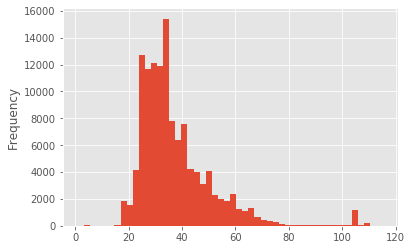

In [25]:
age[age <= 120].plot.hist(bins=50)

In [26]:
# 1920 < age < 2010 - We assume this range as birth year
# so we do 2020 - age as the age 
age = np.where(np.logical_and(age<2010, age>1920), 2020-age, age)
# 2010 < age < 2020 - We assume this range as invalid since it's too young to book
age = np.where(np.logical_and(age<2020, age>2010), 999, age) 

## Label Encoding and One Hot Encoding

In [27]:
pd.set_option('display.max_columns', None) 
user_booking

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,dac_wd_1,dac_wd_2,dac_wd_3,dac_wd_4,dac_wd_5,dac_wd_6,dac_wd_7,dac_season_Fall,dac_season_Spring,dac_season_Summer,dac_season_Winter,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,tfa_season_Fall,tfa_season_Spring,tfa_season_Summer,tfa_season_Winter,dt_span
0,2010-06-28,20090319043255,-unknown-,999.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,1,0,0,0,0,0,0,0,0,1,0,2009,3,19,0,0,0,1,0,0,0,0,1,0,0,70025
1,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,0,0,1,0,0,0,0,0,1,0,0,2009,5,23,0,0,0,0,0,1,0,0,1,0,0,22311
2,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,0,1,0,0,0,0,0,1,0,0,0,2009,6,9,0,1,0,0,0,0,0,0,0,1,0,2833
3,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2011,12,5,1,0,0,0,0,0,0,0,0,0,1,2009,10,31,0,0,0,0,0,1,0,1,0,0,0,64711
4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,9,14,0,1,0,0,0,0,0,1,0,0,0,2009,12,8,0,1,0,0,0,0,0,0,0,0,1,64135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213446,2014-06-30,20140630235636,MALE,32.0,basic,0,en,sem-brand,google,omg,Web,Mac Desktop,Safari,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,204
213447,2014-06-30,20140630235719,-unknown-,999.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,161
213448,2014-06-30,20140630235754,-unknown-,32.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,126
213449,2014-06-30,20140630235822,-unknown-,999.0,basic,25,en,other,other,tracked-other,iOS,iPhone,Mobile Safari,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,2014,6,30,1,0,0,0,0,0,0,0,0,1,0,98


In [28]:
feature_OHE = ['gender', 
               'signup_method', 
               'signup_flow', 
               'language', 
               'affiliate_channel', 
               'affiliate_provider', 
               'first_affiliate_tracked', 
               'signup_app', 
               'first_device_type', 
               'first_browser']

**Label Encoding:**<br/>
* Prerequisite for One-Hot-Encoding.
* http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html<br/>

In [29]:
from sklearn import preprocessing
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
LE_map1=dict()
for cat_var in feature_OHE:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    user_booking[LE_var]=LBL.fit_transform(user_booking[cat_var].fillna('none'))
    LE_vars.append(LE_var)
    LE_map1[cat_var]=dict(zip(LBL.classes_, LBL.transform(LBL.classes_))) ## Here you generate the mapping dictionary
    LE_map[cat_var]=LBL.classes_
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding gender
Label Encoding signup_method
Label Encoding signup_flow
Label Encoding language
Label Encoding affiliate_channel
Label Encoding affiliate_provider
Label Encoding first_affiliate_tracked
Label Encoding signup_app
Label Encoding first_device_type
Label Encoding first_browser
Label-encoded feaures: ['gender_le', 'signup_method_le', 'signup_flow_le', 'language_le', 'affiliate_channel_le', 'affiliate_provider_le', 'first_affiliate_tracked_le', 'signup_app_le', 'first_device_type_le', 'first_browser_le']


In [30]:
LE_map1

{'gender': {'-unknown-': 0, 'FEMALE': 1, 'MALE': 2, 'OTHER': 3},
 'signup_method': {'basic': 0, 'facebook': 1, 'google': 2},
 'signup_flow': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  8: 7,
  10: 8,
  12: 9,
  15: 10,
  16: 11,
  20: 12,
  21: 13,
  23: 14,
  24: 15,
  25: 16},
 'language': {'ca': 0,
  'cs': 1,
  'da': 2,
  'de': 3,
  'el': 4,
  'en': 5,
  'es': 6,
  'fi': 7,
  'fr': 8,
  'hr': 9,
  'hu': 10,
  'id': 11,
  'is': 12,
  'it': 13,
  'ja': 14,
  'ko': 15,
  'nl': 16,
  'no': 17,
  'pl': 18,
  'pt': 19,
  'ru': 20,
  'sv': 21,
  'th': 22,
  'tr': 23,
  'zh': 24},
 'affiliate_channel': {'api': 0,
  'content': 1,
  'direct': 2,
  'other': 3,
  'remarketing': 4,
  'sem-brand': 5,
  'sem-non-brand': 6,
  'seo': 7},
 'affiliate_provider': {'baidu': 0,
  'bing': 1,
  'craigslist': 2,
  'daum': 3,
  'direct': 4,
  'email-marketing': 5,
  'facebook': 6,
  'facebook-open-graph': 7,
  'google': 8,
  'gsp': 9,
  'meetup': 10,
  'naver': 11,
  'other': 12,
  'padmapper': 

**One Hot Encoding:**<br/>
* http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html<br/>

In [31]:
OHE = preprocessing.OneHotEncoder(sparse=False)
start=time.time()
OHE.fit(user_booking[LE_vars])
OHE_data=OHE.transform(user_booking[LE_vars])
                                   
print ('One-hot-encoding finished in %f seconds' % (time.time()-start))


OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_')\
                for var in feature_OHE for level in LE_map[var]]

print ("OHE size :" ,OHE_data.shape)
print ("One-hot encoded catgorical feature samples : %s" % (OHE_vars[:100]))

One-hot-encoding finished in 1.336796 seconds
OHE size : (213451, 148)
One-hot encoded catgorical feature samples : ['gen_-unknown-', 'gen_FEMALE', 'gen_MALE', 'gen_OTHER', 'signup_met_basic', 'signup_met_facebook', 'signup_met_google', 'signup_f_0', 'signup_f_1', 'signup_f_2', 'signup_f_3', 'signup_f_4', 'signup_f_5', 'signup_f_6', 'signup_f_8', 'signup_f_10', 'signup_f_12', 'signup_f_15', 'signup_f_16', 'signup_f_20', 'signup_f_21', 'signup_f_23', 'signup_f_24', 'signup_f_25', 'langu_ca', 'langu_cs', 'langu_da', 'langu_de', 'langu_el', 'langu_en', 'langu_es', 'langu_fi', 'langu_fr', 'langu_hr', 'langu_hu', 'langu_id', 'langu_is', 'langu_it', 'langu_ja', 'langu_ko', 'langu_nl', 'langu_no', 'langu_pl', 'langu_pt', 'langu_ru', 'langu_sv', 'langu_th', 'langu_tr', 'langu_zh', 'affiliate_chan_api', 'affiliate_chan_content', 'affiliate_chan_direct', 'affiliate_chan_other', 'affiliate_chan_remarketing', 'affiliate_chan_sem-brand', 'affiliate_chan_sem-non-brand', 'affiliate_chan_seo', 'affili

In [32]:
user_booking = pd.concat((user_booking, pd.DataFrame(OHE_data,columns=OHE_vars)), axis = 1)

In [33]:
user_booking.head()

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,dac_wd_1,dac_wd_2,dac_wd_3,dac_wd_4,dac_wd_5,dac_wd_6,dac_wd_7,dac_season_Fall,dac_season_Spring,dac_season_Summer,dac_season_Winter,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,tfa_season_Fall,tfa_season_Spring,tfa_season_Summer,tfa_season_Winter,dt_span,gender_le,signup_method_le,signup_flow_le,language_le,affiliate_channel_le,affiliate_provider_le,first_affiliate_tracked_le,signup_app_le,first_device_type_le,first_browser_le,gen_-unknown-,gen_FEMALE,gen_MALE,gen_OTHER,signup_met_basic,signup_met_facebook,signup_met_google,signup_f_0,signup_f_1,signup_f_2,signup_f_3,signup_f_4,signup_f_5,signup_f_6,signup_f_8,signup_f_10,signup_f_12,signup_f_15,signup_f_16,signup_f_20,signup_f_21,signup_f_23,signup_f_24,signup_f_25,langu_ca,langu_cs,langu_da,langu_de,langu_el,langu_en,langu_es,langu_fi,langu_fr,langu_hr,langu_hu,langu_id,langu_is,langu_it,langu_ja,langu_ko,langu_nl,langu_no,langu_pl,langu_pt,langu_ru,langu_sv,langu_th,langu_tr,langu_zh,affiliate_chan_api,affiliate_chan_content,affiliate_chan_direct,affiliate_chan_other,affiliate_chan_remarketing,affiliate_chan_sem-brand,affiliate_chan_sem-non-brand,affiliate_chan_seo,affiliate_provi_baidu,affiliate_provi_bing,affiliate_provi_craigslist,affiliate_provi_daum,affiliate_provi_direct,affiliate_provi_email-marketing,affiliate_provi_facebook,affiliate_provi_facebook-open-graph,affiliate_provi_google,affiliate_provi_gsp,affiliate_provi_meetup,affiliate_provi_naver,affiliate_provi_other,affiliate_provi_padmapper,affiliate_provi_vast,affiliate_provi_wayn,affiliate_provi_yahoo,affiliate_provi_yandex,first_affiliate_trac_linked,first_affiliate_trac_local_ops,first_affiliate_trac_marketing,first_affiliate_trac_none,first_affiliate_trac_omg,first_affiliate_trac_product,first_affiliate_trac_tracked-other,first_affiliate_trac_untracked,signup__Android,signup__Moweb,signup__Web,signup__iOS,first_device_t_Android_Phone,first_device_t_Android_Tablet,first_device_t_Desktop_(Other),first_device_t_Mac_Desktop,first_device_t_Other/Unknown,first_device_t_SmartPhone_(Other),first_device_t_Windows_Desktop,first_device_t_iPad,first_device_t_iPhone,first_brow_-unknown-,first_brow_AOL_Explorer,first_brow_Android_Browser,first_brow_Apple_Mail,first_brow_Arora,first_brow_Avant_Browser,first_brow_BlackBerry_Browser,first_brow_Camino,first_brow_Chrome,first_brow_Chrome_Mobile,first_brow_Chromium,first_brow_CometBird,first_brow_Comodo_Dragon,first_brow_Conkeror,first_brow_CoolNovo,first_brow_Crazy_Browser,first_brow_Epic,first_brow_Firefox,first_brow_Flock,first_brow_Google_Earth,first_brow_Googlebot,first_brow_IE,first_brow_IE_Mobile,first_brow_IceDragon,first_brow_IceWeasel,first_brow_Iron,first_brow_Kindle_Browser,first_brow_Maxthon,first_brow_Mobile_Firefox,first_brow_Mobile_Safari,first_brow_Mozilla,first_brow_NetNewsWire,first_brow_OmniWeb,first_brow_Opera,first_brow_Opera_Mini,first_brow_Opera_Mobile,first_brow_Outlook_2007,first_brow_PS_Vita_browser,first_brow_Pale_Moon,first_brow_Palm_Pre_web_browser,first_brow_RockMelt,first_brow_Safari,first_brow_SeaMonkey,first_brow_Silk,first_brow_SiteKiosk,first_brow_SlimBrowser,first_brow_Sogou_Explorer,first_brow_Stainless,first_brow_TenFourFox,first_brow_TheWorld_Browser,first_brow_Yandex.Browser,first_brow_wOSBrowser
0,2010-06-28,20090319043255,-unknown-,999.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,1,0,0,0,0,0,0,0,0,1,0,2009,3,19,0,0,0,1,0,0,0,0,1,0,0,70025,0,1,0,5,2,4,7,2,3,8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [34]:
user_booking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Columns: 200 entries, date_account_created to first_brow_wOSBrowser
dtypes: float64(149), int64(19), object(10), uint8(22)
memory usage: 294.4+ MB


## Model Building

### Evaluation methods

#### Confusion matrix

* Regular way to evaluate a classification method, binary or multiple labels.

#### Normalized Discounted Cumulative Gain(NDCG) score

* NDCG is a measure of ranking quality
* Since we have multiple destinations, and our system would like to predict(recommend) multiple destinations to each user, so we rank the destinations for each user by probability, and evaluate the ranking by NDCG score
* https://en.wikipedia.org/wiki/Discounted_cumulative_gain

In [35]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelBinarizer

def dcg_score(y_true, y_score, k=5):
    
    """
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.
        
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

### Label encoding target variable - destination

In [36]:
labels_le = preprocessing.LabelEncoder()
user_booking_label = labels_le.fit_transform(labels)
label_map = dict(zip(labels_le.classes_, labels_le.transform(labels_le.classes_)))

In [37]:
label_map

{'AU': 0,
 'CA': 1,
 'DE': 2,
 'ES': 3,
 'FR': 4,
 'GB': 5,
 'IT': 6,
 'NDF': 7,
 'NL': 8,
 'PT': 9,
 'US': 10,
 'other': 11}

### Prepare data for modeling

In [38]:
from sklearn.model_selection import train_test_split

# we have created date time feature and one hot encoding the categorical features
# so drop the original features
user_booking_features = user_booking.drop(['date_account_created','timestamp_first_active'],axis=1)\
    .drop(feature_OHE+LE_vars,axis=1)

user_booking_label = user_booking_label

x_train, x_validation, y_train, y_validation = train_test_split(user_booking_features, user_booking_label,\
                                                    test_size=0.2, random_state=42)

## Modeling - Logistic Regression

In [39]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [40]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# classification report showed the confusion matrix is not a good evaluation metrics
predict_label = lr.predict(x_validation)
print(classification_report(y_validation, predict_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.00      0.00      0.00       275
           2       0.00      0.00      0.00       208
           3       0.00      0.00      0.00       451
           4       0.00      0.00      0.00      1010
           5       0.00      0.00      0.00       497
           6       0.00      0.00      0.00       562
           7       0.58      1.00      0.74     24843
           8       0.00      0.00      0.00       155
           9       0.00      0.00      0.00        45
          10       0.00      0.00      0.00     12525
          11       0.00      0.00      0.00      2006

    accuracy                           0.58     42691
   macro avg       0.05      0.08      0.06     42691
weighted avg       0.34      0.58      0.43     42691



In [42]:
predicted_probabilities = lr.predict_proba(x_validation)

# sort the output by their probability
# show the destination ranking result of data point at position 1
# descending order
# the first destination is 7 - which is NDF, second is 10-US
print(np.argsort(predicted_probabilities[1])[::-1])

# show the probabilities of each destination(0,1,2,3...)
# of data point at position 1
print(predicted_probabilities[1])

[ 7 10 11  4  6  3  5  1  2  8  0  9]
[1.05766673e-03 4.06677759e-03 2.60594181e-03 6.92037519e-03
 1.65452560e-02 6.57183677e-03 9.33210486e-03 7.59574758e-01
 2.11328725e-03 6.70263092e-04 1.62556569e-01 2.79851641e-02]


In [43]:
# we want to evaluate the top 5 destination for each user
k_ndcg = 5
validation_ndcg_score = ndcg_score(y_validation, predicted_probabilities, k = k_ndcg)
validation_ndcg_score

0.805808947197359

### Decision Tree

In [44]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [45]:
# classification report showed the confusion matrix is not a good evaluation metrics
predict_label = dt.predict(x_validation)
print(classification_report(y_validation, predict_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.01      0.01      0.01       275
           2       0.01      0.01      0.01       208
           3       0.02      0.02      0.02       451
           4       0.03      0.03      0.03      1010
           5       0.01      0.01      0.01       497
           6       0.02      0.02      0.02       562
           7       0.67      0.65      0.66     24843
           8       0.01      0.01      0.01       155
           9       0.00      0.00      0.00        45
          10       0.38      0.38      0.38     12525
          11       0.07      0.07      0.07      2006

    accuracy                           0.49     42691
   macro avg       0.10      0.10      0.10     42691
weighted avg       0.50      0.49      0.50     42691



In [46]:
predicted_probabilities = dt.predict_proba(x_validation)

# sort the output by their probability
# show the destination ranking result of data point at position 1
# descending order
# the first destination is 7 - which is NDF, second is 10-US
print(np.argsort(predicted_probabilities[1])[::-1])

# show the probabilities of each destination(0,1,2,3...)
# of data point at position 1
print(predicted_probabilities[1])

[10 11  9  8  7  6  5  4  3  2  1  0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [47]:
# we want to evaluate the top 5 destination for each user
k_ndcg = 5
validation_ndcg_score = ndcg_score(y_validation, predicted_probabilities, k = k_ndcg)
validation_ndcg_score

0.6808685014884035

### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
# classification report showed the confusion matrix is not a good evaluation metrics
predict_label = rf.predict(x_validation)
print(classification_report(y_validation, predict_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.01      0.00      0.01       275
           2       0.00      0.00      0.00       208
           3       0.02      0.00      0.01       451
           4       0.04      0.01      0.02      1010
           5       0.03      0.01      0.01       497
           6       0.02      0.01      0.01       562
           7       0.65      0.79      0.72     24843
           8       0.00      0.00      0.00       155
           9       0.00      0.00      0.00        45
          10       0.43      0.38      0.40     12525
          11       0.05      0.01      0.02      2006

    accuracy                           0.57     42691
   macro avg       0.10      0.10      0.10     42691
weighted avg       0.51      0.57      0.54     42691



In [50]:
predicted_probabilities = rf.predict_proba(x_validation)

# sort the output by their probability
# show the destination ranking result of data point at position 1
# descending order
# the first destination is 7 - which is NDF, second is 10-US
print(np.argsort(predicted_probabilities[1])[::-1])

# show the probabilities of each destination(0,1,2,3...)
# of data point at position 1
print(predicted_probabilities[1])

[ 7 10 11  9  8  6  5  4  3  2  1  0]
[0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.2 0. ]


In [51]:
# we want to evaluate the top 5 destination for each user
k_ndcg = 5
validation_ndcg_score = ndcg_score(y_validation, predicted_probabilities, k = k_ndcg)
validation_ndcg_score

0.7782205275019416

### Random Forest Parameter Tuning

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
def search_model(x_train, y_train, est, param_grid, n_jobs, cv):
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring = 'f1_weighted',
                                     verbose = 10,
                                     n_jobs = n_jobs,
                                     iid = True,
                                     cv = cv)
    # Fit Grid Search Model
    model.fit(x_train, y_train)   
    return model

In [53]:
param_grid = {'n_estimators':[300,500],
             'max_depth':[8,9],
             'min_samples_split': [3,4]}

RF = search_model(x_train
            , y_train
            , RandomForestClassifier()
            , param_grid
            , -1
            , 3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done   4 out of  24 | elapsed:  8.1min remaining: 40.5min
[Parallel(n_jobs=-1)]: Done   7 out of  24 | elapsed:  9.4min remaining: 22.8min
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:  9.4min remaining: 13.2min
[Parallel(n_jobs=-1)]: Done  13 out of  24 | elapsed: 10.2min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed: 11.0min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed: 11.0min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed: 11.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 11.4min finished


In [54]:
print("Best score: %0.3f" % RF.best_score_)
print("Best parameters set:", RF.best_params_)

Best score: 0.513
Best parameters set: {'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 300}


In [55]:
# we want to evaluate the top 5 destination for each user
k_ndcg = 5
predicted_probabilities = RF.predict_proba(x_validation)
validation_ndcg_score = ndcg_score(y_validation, predicted_probabilities, k = k_ndcg)
validation_ndcg_score

0.8139045838685168